# Convolutional Neural Networks for Classifying Fashion-MNIST Dataset using Ignite
This is a tutorial on using Ignite to train neural network models, setup experiments and validate models.

In this notebook, we will be doing classification of images using Convolutional Neural Networks 

We will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) Fashion-MNIST is a set of 28x28 greyscale images of clothes.

![Fashion MNIST dataset](assets/fashion-mnist.png)

Lets get started!

### Importing libraries

General Data-Science Libraries like numpy, matplotlib and seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

We import `torch`, `nn` and `functional` modules to create our models.

We also import `datasets` and `transforms` from torchvision for loading the dataset and applying transforms to the images in the dataset.

We import `dataloader` for making train and validation loader for loading data into our model.

In [2]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

`Ignite` is a High-level library to help with training neural networks in PyTorch. It comes with an `Engine` to setup a training loop, various metrics, handlers and a helpful contrib section! 

Below we import the following:
* **Engine**: Runs a given process_function over each batch of a dataset, emitting events as it goes.
* **Events**: Allows users to attach functions to an `Engine` to fire functions at a specific event. Eg: `EPOCH_COMPLETED`, `ITERATION_STARTED`, etc.
* **Accuracy**: Metric to calculate accuracy over a dataset, for binary, multiclass, multilabel cases. 
* **Loss**: General metric that takes a loss function as a parameter, calculate loss over a dataset.
* **RunningAverage**: General metric to attach to Engine during training. 
* **ModelCheckpoint**: Handler to checkpoint models. 
* **EarlyStopping**: Handler to stop training based on a score function. 

In [3]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy,Loss,RunningAverage,ConfusionMatrix
from ignite.handlers import ModelCheckpoint,EarlyStopping

The code below first sets up transform using `torhvision transfroms` for converting images to pytorch tensors and normalizing the images.

Next, We use `torchvision datasets` for dowloading the fashion mnist dataset and applying transforms which we defined above.

* `trainset` contains the training data.
* `validationset` contains the validation data

Next, We use `pytorch dataloader` for making dataloader from the train and validation sets.

In [4]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

### CNN Model

Explanation of Model Architecture

* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), the Convolutional layer is used to create a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), the Maxpooling layer is used to downsample an input representation keeping the most active pixels from the previous layer.
* The usual [Linear](https://pytorch.org/docs/stable/nn.html#linear) + [Dropout](https://pytorch.org/docs/stable/nn.html#dropout2d) layers to avoid overfitting and produce a 10-dim output.
* The output of Convolutional layer is determined by W'(new dimension) = (W-F+2P)/S + 1 here W is dimension 28(28 x 28) and F is the number of filters and P is the amount of padding and S is the amount of stride.
* After second convolutional layer and max pooling we get the output as 64x4x4
* We convert this 64x4x4 output to the flat tensor by using pytorch tensor [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method
* Then we pass this flat tensor to the fully connected layers
* We had used [Relu](https://pytorch.org/docs/stable/nn.html#id27) Non Linearity for the model and [logsoftmax](https://pytorch.org/docs/stable/nn.html#log-softmax) at the last layer because we are going to use the [NLLL loss](https://pytorch.org/docs/stable/nn.html#nllloss).


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=4)
        self.conv2 = nn.Conv2d(64,64,kernel_size=4)

        self.drop1 = nn.Dropout2d(p=0.1)
        self.drop2 = nn.Dropout2d(p=0.3)
        self.fc1 = nn.Linear(64*4*4,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
    
    def forward(self,x):
        x = self.drop1(F.max_pool2d(F.relu(self.conv1(x)),2))
        x = self.drop2(F.max_pool2d(F.relu(self.conv2(x)),2))
        x = x.view(-1,64*4*4)
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

### Creating Model, Optimizer and Loss

Below we create an instance of the CNN model. The model is placed on a device and then a loss function of `negative log likelihood loss` and `Adam optimizer` with learning rate of 0.003 are setup. 

In [6]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()

### Training and Evaluating using Ignite

### Instantiating Training and Evaluating Engines

Below we create 2 engines, a trainer, and a evaluator. By using the `create_supervised_trainer` and `create_supervised_evaluator` by passing the required arguments.

* `training history`: it stores the training loss and accuracy
* `validation history`:it stores the validation loss and accuracy
* `last_epoch`: it stores the last epoch untill the model is trained


In [7]:
# defining the number of epochs
epochs = 20
# creating trainer,evaluator
trainer = create_supervised_trainer(model,optimizer,criterion,device=device)
evaluator = create_supervised_evaluator(model,metrics={'accuracy':Accuracy(),'nll':Loss(criterion),'cm':ConfusionMatrix(num_classes=10)},device=device)
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

### Metrics - RunningAverage, Accuracy and Loss

To start, we will attach a metric of `Running Average` to track a running average of the scalar loss output for each batch. 

In [8]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

### EarlyStopping - Tracking Validation Loss

Now we will setup a `Early Stopping` handler for this training process. EarlyStopping requires a score_function that allows the user to define whatever criteria to stop trainig. In this case, if the loss of the validation set does not decrease in 10 epochs, the training process will stop early.  

In [9]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

### Attaching Custom Functions to Engine at specific Events

Below you will see ways to define your own custom functions and attaching them to various `Events` of the training process.

The functions below both achieve similar tasks, they print the results of the evaluator run on a dataset. One function does that on the training evaluator and dataset, while the other on the validation. Another difference is how these functions are attached in the trainer engine.

The first method involves using a decorator, the syntax is simple - `@` `trainer.on(Events.EPOCH_COMPLETED)`, means that the decorated function will be attached to the trainer and called at the end of each epoch. 

The second method involves using the add_event_handler method of trainer - `trainer.add_event_handler(Events.EPOCH_COMPLETED, custom_function)`. This achieves the same result as the above. 

In [10]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)    



### Confusion Matrix

Confusion matrix gives us a better idea of what our classification model is getting right and what types of errors it is making.

We visualize the `confusion matrix` using the `seaborn.heatmap` from `seaborn` library.

In [11]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

### ModelCheckpoint

Lastly, we want to checkpoint this model. It's important to do so, as training processes can be time consuming and if for some reason something goes wrong during training, a model checkpoint can be helpful to restart training from the point of failure.

Below we will use Ignite's `ModelCheckpoint` handler to checkpoint models at the end of each epoch.

In [12]:
checkpointer = ModelCheckpoint('./models', 'fashionMNIST', save_interval=1, n_saved=2, create_dir=True, save_as_state_dict=True,require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

### Run Engine

Next, we will run the trainer for 50 epochs and monitor results. Below we can see that custom functions defined above helps prints the `loss` and `accuracy` per epoch.  


Training Results - Epoch: 1  Avg accuracy: 80.79 Avg loss: 0.52
Validation Results - Epoch: 1  Avg accuracy: 80.04 Avg loss: 0.55
Training Results - Epoch: 2  Avg accuracy: 84.07 Avg loss: 0.45
Validation Results - Epoch: 2  Avg accuracy: 83.48 Avg loss: 0.48
Training Results - Epoch: 3  Avg accuracy: 85.22 Avg loss: 0.42
Validation Results - Epoch: 3  Avg accuracy: 84.59 Avg loss: 0.45
Training Results - Epoch: 4  Avg accuracy: 86.53 Avg loss: 0.38
Validation Results - Epoch: 4  Avg accuracy: 85.09 Avg loss: 0.43
Training Results - Epoch: 5  Avg accuracy: 86.93 Avg loss: 0.37
Validation Results - Epoch: 5  Avg accuracy: 85.46 Avg loss: 0.42
Training Results - Epoch: 6  Avg accuracy: 87.02 Avg loss: 0.37
Validation Results - Epoch: 6  Avg accuracy: 85.66 Avg loss: 0.42
Training Results - Epoch: 7  Avg accuracy: 86.81 Avg loss: 0.37
Validation Results - Epoch: 7  Avg accuracy: 85.00 Avg loss: 0.41
Training Results - Epoch: 8  Avg accuracy: 87.77 Avg loss: 0.35
Validation Results - Epoch

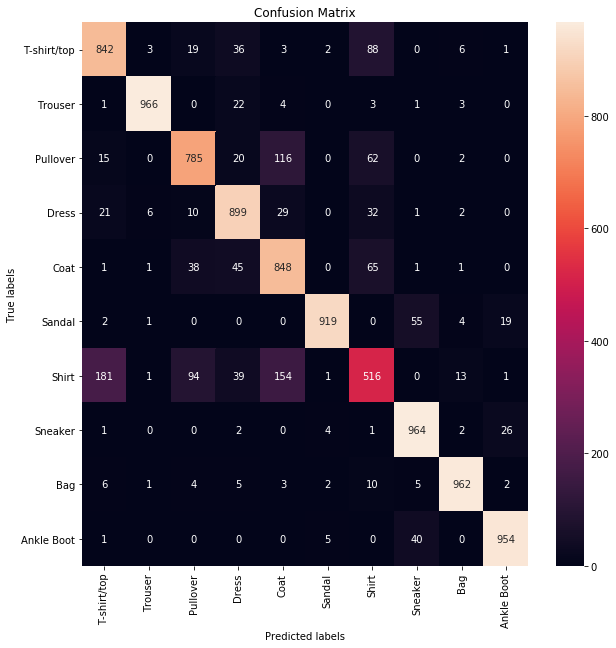

In [13]:
trainer.run(train_loader, max_epochs=epochs)

### Plotting the loss and accuracy
Next, we will plot the loss and accuracy which we have stored in the `training_history` and `validation_history` dictionary to see how loss and accuracy are changing with each epoch.

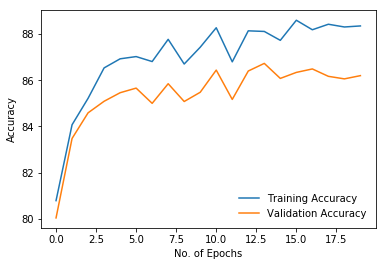

In [14]:
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

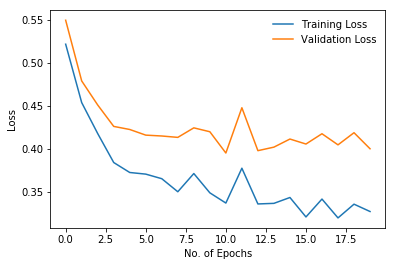

In [15]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk
Loading the saved pytorch model from the disk for inferencing.

In [16]:
# loading the saved model
model.load_state_dict(torch.load('models/fashionMNIST_fashionMNIST_'+str(len(last_epoch))+'.pth'))

### Inferencing the model 
Below code will be used for inferencing from the model and visualizing the results.

Here we do iteration from the `val_loader` and then select the class with highest probability and then compare it with actul class.

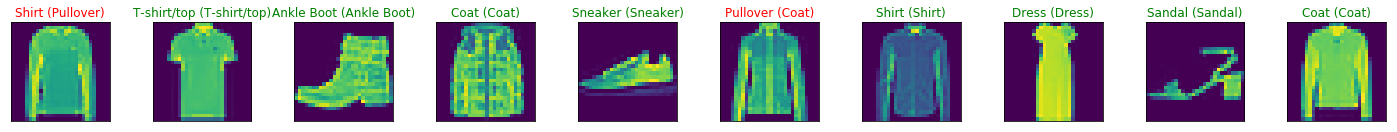

In [17]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(val_loader)
images, labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference 
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))

### Refrences 
* [Pytorch Ignite Text CNN example notebook](https://github.com/pytorch/ignite/blob/master/examples/notebooks/TextCNN.ipynb)
* [Pytorch Ignite MNIST example](https://github.com/pytorch/ignite/blob/master/examples/mnist/mnist.py)